In [1]:
from multirotor import MultiRotor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from celluloid import Camera
from matplotlib.animation import FuncAnimation

In [2]:
class mfac(nn.Module):
    def __init__(self, layer_sizes):
        super(mfac, self).__init__()
        
        self.first_layer = torch.zeros(layer_sizes[0])
        
        self.hidden_layers = [
            nn.Sequential(nn.Linear(nlminus1, nl), nn.ReLU())
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]
        
        self.output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])
        
        self.layers = nn.Sequential(*self.hidden_layers, self.output_layer)
        
    def forward(self, x):
        
        first_layer_tensor = torch.roll(self.first_layer, 1)
        first_layer_tensor[0] = x
        
        #HELP
        e = self.layers(first_layer_tensor)
        return e

In [3]:
# Simulation timing
time_start = 0
time_stop = 30
num_time_points = 1000
time = torch.linspace(time_start, time_stop, num_time_points)
time_step = time[1] - time[0]

In [4]:
mr = MultiRotor(dt=time_step)

# The input layer size
n0 = 5

# The output layer
nL = 1

# Hidden layers' sizes
neurons_per_layer = [13, 17]

# Preprend the input and append the output layer sizes
layer_sizes = [n0] + neurons_per_layer + [nL]

net = mfac(layer_sizes)

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [6]:
# Altitude target (setpoint) is up 10m
altitude_setpoint = mr.get_altitude() + 10

In [7]:
# Initialize variables to keep track of data for animation
time_data = []
altitude_data = []

In [8]:
for t in time:
    error = float(altitude_setpoint - mr.get_altitude())
    output = net(error)
    curr_altitude, curr_velocity = mr.step(output.item())
    
    optimizer.zero_grad()
    loss = criterion(output, torch.as_tensor([error]))
    loss.backward()
    optimizer.step()
    
    time_data.append(t)
    altitude_data.append(curr_altitude.item())

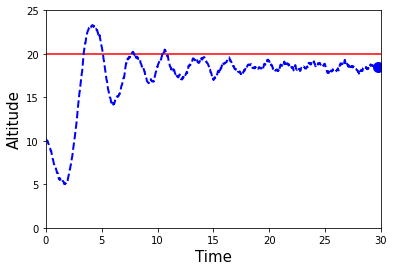

In [9]:
# frames.append(observation.copy())

# Initialize subplots
fig, ax = plt.subplots()

# St axis of animation
ax.set(xlim=(0,30), ylim=(0, 25))

# Labels
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Altitude', fontsize=15);



# Initiate camera
camera = Camera(fig)

for i in range(0, num_time_points, 10):
    ax.axhline(y=altitude_setpoint, color='r')
    
    ax.plot(time_data[i], altitude_data[i], marker='o', markersize=10, markeredgecolor='b', markerfacecolor='b')
    
    # Show Projectile's trajectory
    ax.plot(time_data[0:i], altitude_data[0:i], color='b', lw=2, linestyle='--')
    
    # Capture frame
    camera.snap()

from IPython.display import HTML

# Create animation
anim = camera.animate(interval = 1, repeat = True, repeat_delay = 100)

HTML(anim.to_jshtml())

# Save animation
anim.save("mfac_sim" + ".gif")